In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

In [2]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data', 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

In [3]:
batch_size = 128

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = batch_size)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, output_dim)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            if 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)

In [6]:
criterion = nn.CrossEntropyLoss()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [8]:
def train_epoch(iterator, model, optimizer, criterion, device):
    
    losses = []

    for images, labels in tqdm.tqdm(iterator):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(images)

        loss = criterion(predictions, labels)

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

    return losses

In [9]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=5):

    losses = []

    model.init_params()

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)

    return losses

In [10]:
def plot_loss(loss, title=None):
    fig, ax = plt.subplots()
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=0)
    ax.grid()

## Optimizer 1: Stochastic Gradient Descent (SGD)

$$\theta = \theta - \eta \cdot \nabla_\theta J(\theta)$$

In English:
- $\theta$ is your model parameters
- $\eta$ is the learning rate
- $\nabla_\theta$ is the gradient of the parameters
- $J$ is the loss function
- $\nabla_\theta J(\theta)$ is the gradient of the paramters with respect to the loss achived by those parameters

We subtract because we want to descend the gradient by moving towards the nearby minima. Addition would ascend the gradient.

In [11]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

In [12]:
optimizer = SGD(model.parameters())

In [13]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 49.57it/s]


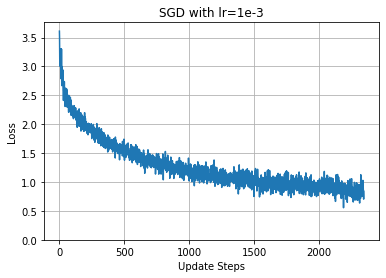

In [14]:
plot_loss(sgd_loss, 'SGD with lr=1e-3')

## Optimizer 2: SGD with Momentum

\begin{align}
    v &= \gamma \cdot v + \eta \cdot \nabla_\theta J(\theta)\\
    \theta &= \theta - v\\
\end{align}

In English:
- $\gamma$ is the momentum
- $v$ is the velocity

In PyTorch they actually do:

\begin{align}
    v &= \gamma \cdot v + \nabla_\theta J(\theta)\\
    \theta &= \theta - \eta \cdot v\\
\end{align}

We copy the PyTorch implementation.

In [15]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * v)

In [16]:
optimizer = SGDMomentum(model.parameters())

In [17]:
sgd_momentum_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 48.39it/s]


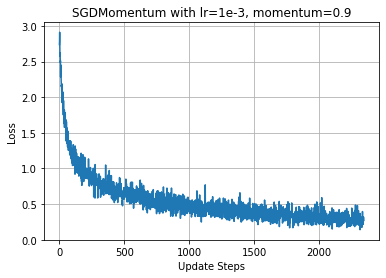

In [18]:
plot_loss(sgd_momentum_loss, 'SGDMomentum with lr=1e-3, momentum=0.9')

## Optimizer 3: Nesterov Accelerated Gradient (NAG)

\begin{align}
    v &= \gamma \cdot v + \eta \cdot \nabla_\theta J(\theta - \gamma \cdot v)\\
    \theta &= \theta - v\\
\end{align}

Update parameters based on what the loss will be after the parameter update.

In PyTorch they actually do:

\begin{align}
    v &= \gamma \cdot v + \nabla_\theta J(\theta)\\
    \theta &= \theta - \eta \cdot \Big(\nabla_\theta J(\theta) + \gamma \cdot v \Big)\\
\end{align}

We copy the PyTorch implementation.

In [19]:
class NAG:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * (param.grad + v * self.momentum))

In [20]:
optimizer = NAG(model.parameters())

In [21]:
nag_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 48.31it/s]


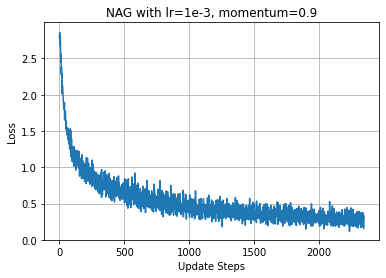

In [22]:
plot_loss(nag_loss, 'NAG with lr=1e-3, momentum=0.9')

In [23]:
def plot_losses(losses, labels, title=None):
    fig, ax = plt.subplots()
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=0)
    ax.grid()
    ax.legend(loc='upper right')

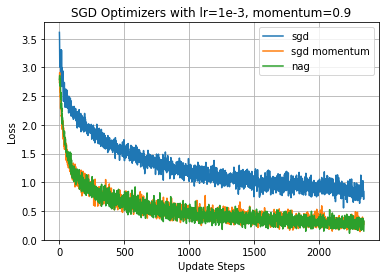

In [24]:
losses = [sgd_loss, sgd_momentum_loss, nag_loss]
labels = ['sgd', 'sgd momentum', 'nag']

plot_losses(losses, labels, 'SGD Optimizers with lr=1e-3, momentum=0.9')